# Importing Libraries
We are mainly using openCV, keras, tensorflow libraries for this research. The purpose of this research is to find out the best performing model than can classify shoplifiting from videos and provide alert signals to the shop incharges to prevent this outlaw. We are going to try our best to find the best model and parameter that will show case the best performance.  

### The models that we will try out are
- VGG16 (224 x 224 x 3)
- VGG19 (224 x 224 x 3)
- ResNet50 (224 x 224 x 3)
- DenseNet121 (224 x 224 x 3)
- InceptionV3 (299 x 299 x 3)

The first task is to import the libraries - 

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as p
import imutils

from scipy import ndimage
from moviepy.editor import *
from PIL import Image
from tqdm import tqdm

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications import ResNet50, VGG16, VGG19, DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Input, ZeroPadding2D, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.utils.vis_utils import plot_model, model_to_dot


from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
from sklearn import preprocessing

In [2]:
outputmodelpath = r'model/'
outputbinarizerpath = r'model/'

DATA_DIR = './data'
CATEGORIES = ['Shoplifting', 'Normal_Activity']

data = []
labels = []

We are declaring some paths to save our **model** and **binarizer**. Now, we will start our preprocessing. The first step is to load the **images correctly**.


# Preprocessing

In [3]:
def preprocess_data_to_images(IMG_SIZE = 224):
    pathOut = "./sample"
    count = 0
    counter = 1

    frames = []

    for c in CATEGORIES:
        path = os.path.join(DATA_DIR, c)
        class_num = CATEGORIES.index(c)

        for vid in tqdm(os.listdir(path)):
            try:
                vid = os.path.join(path, vid)
                cap = cv2.VideoCapture(vid)
                count = 0
                counter += 1
                success = True
                while success:
                    success,image = cap.read()
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            #         print('read a new frame:',success)
                    if count%30 == 0 :
                        frames.append([image, class_num])
                        cv2.imwrite(pathOut + 'frame%d.jpg'%count,image)
                    count+=1
            except Exception as e:
                pass

    print(count, " frames extracted")
    # frames = np.array(frames)
    # print("data shape =\t", frames.shape)

In [4]:
def preprocess_data(IMG_SIZE = 224, data=[], labels=[]):
    for c in CATEGORIES:
        path = os.path.join(DATA_DIR, c)
        class_num = CATEGORIES.index(c)

        for img in  tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_COLOR)
                img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([img_resized, class_num])
                labels.append(CATEGORIES[class_num])
            except Exception as e:
                pass
    print("--------------------------")
    print("Images loaded successfully!")
    print(f"Found {len(data)} images and {len(labels)} labels from {len(CATEGORIES)} Categories")
    #data = np.array(data)
    #np.random.shuffle(data)
    return data, labels

# Visualizing the images for visual assessment of the data

In [5]:
def plot_image_data(data=[]):
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(data[i][0])
        plt.xlabel(CATEGORIES[data[i][1]])
    plt.show()

# Splitting the Data into train and test splits

In [6]:
def split_data(data):    
    x = []
    y = []

    for i in range(len(data)):
        x.append(data[i][0])
        y.append(data[i][1])

    x = np.array(x)
    y = np.array(y)

    lb = preprocessing.LabelBinarizer()
    y = lb.fit_transform(y)

    train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, stratify = y, random_state=42)
    
    return lb, train_x, test_x, train_y, test_y

# Augmenting the data for better training

In [7]:
def augment_data(train_x, train_y, test_x, test_y):    
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
    train_gen = train_datagen.flow(train_x, train_y, batch_size=32)

    validation_datagen = ImageDataGenerator(rescale=1.0/255)
    validation_gen = validation_datagen.flow(test_x, test_y)
    
    return train_gen, validation_gen
    

def augment_data_resnet():
    global train_gen, validation_gen

    train_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)
    validation_datagen = ImageDataGenerator(dtype='float32',preprocessing_function=preprocess_input)
    
    train_gen = train_datagen.flow(train_x, train_y, batch_size=32)
    validation_gen = validation_datagen.flow(test_x, test_y)

# Model Creation

## VGG16

In [8]:
def model_vgg16():
    baseModel = VGG16(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))
    
    headModel = baseModel.output
    headModel = MaxPooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
    model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

## VGG19

In [9]:
def model_vgg19():
    baseModel = VGG19(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))
    headModel = baseModel.output
    headModel = MaxPooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
    
    return model

## ResNet50

In [10]:
def model_resnet50():
    baseModel = ResNet50(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))
    
    headModel = baseModel.output
    headModel = MaxPooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.75)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
    
    return model

# DenseNet121

In [11]:
def model_densenet121():
    baseModel = DenseNet121(weights="imagenet", include_top = False, input_tensor = Input(shape=(224,224,3)))
    headModel = baseModel.output
    headModel = MaxPooling2D(pool_size=(7,7))(headModel)
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(100, activation="relu")(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = Dense(20, activation="relu")(headModel)
    headModel = Dropout(0.2)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
    
    return model

## InceptionV3

In [12]:
def model_inceptionV3():
    baseModel = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(299,299,3)), pooling='avg')
    
    headModel = baseModel.output
    headModel = Flatten(name="Flatten")(headModel)
    headModel = Dense(2048, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1024, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(512, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(256, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(128, activation="relu")(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(1, activation="sigmoid")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    
#     headModel = Dense(1000, activation="relu")(headModel)
#     headModel = Dropout(0.2)(headModel)
#     headModel = Dense(200, activation="relu")(headModel)
#     headModel = Dropout(0.2)(headModel)
#     headModel = Dense(40, activation="relu")(headModel)
#     headModel = Dropout(0.2)(headModel)
#     headModel = Dense(1, activation="sigmoid")(headModel)
#     model = Model(inputs=baseModel.input, outputs=headModel)
    
    for basemodellayers in baseModel.layers:
        basemodellayers.trainable = False
        
    return model

## Custom

In [13]:
def model_custom():
    model = Sequential()
    model.add(Conv2D(100, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
    model.add(Conv2D(100, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(50, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(50, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Conv2D(25, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(25, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(25, activation='relu'))
    model.add(Dropout(0.5))
    
    return model

# Train the model

In [14]:
def train_model(train_gen, validation_gen, train_len, test_len, model, epch = 10, opt = SGD(learning_rate=0.01), ls = "binary_crossentropy", met = ["accuracy"]):
    
    model.compile(loss=ls, optimizer=opt, metrics=met)
    
    history = model.fit_generator(
        train_gen,
        steps_per_epoch = train_len//32,
        validation_data = validation_gen,
        validation_steps = test_len//32,
        epochs = epch
    )
    
    return history

# Test the model

In [15]:
def test_model(model, test_x, test_y):
    score = model.evaluate(test_x, test_y, verbose=0)
    return score

# kfold model history

In [16]:
def get_kfold_history(data, model, opt = SGD(learning_rate=0.01), ls = "binary_crossentropy", met = ["accuracy"], k=5, epoch=10):
    # Split data     
    X = [datum[0] for datum in data]
    y = [datum[1] for datum in data]

    X = np.array(X)
    y = np.array(y)

    # Define cross-validation folds
    kf = KFold(n_splits=k, shuffle=True)

    # Perform cross-validation
    history = []
    test_history = []
    fold = 1
    for train_idx, test_idx in kf.split(X):
        print(f'Fold {fold}:')
        train_x, train_y = X[train_idx], y[train_idx]
        test_x, test_y = X[test_idx], y[test_idx]

        # Augment data
        train_gen, validation_gen = augment_data(train_x, train_y, test_x, test_y)

        # Define models
        mod = model

        # Train model
        history.append(train_model(train_gen, validation_gen, len(train_x), len(test_x), mod, epoch, opt, ls))

        # Test Model
        test_history.append(test_model(mod, test_x, test_y))

        fold += 1
    return history

# Saving the Model, History, and the Binarizer

In [17]:
def save_model(model):
    model.save(outputmodelpath)
    lbinarizer = open(outputbinarizerpath)
    lbinarizer.write(p.dump(lb))
    lbinarizer.close()


def save_history_as_pickle(history):
    with open('/trainHistoryDict', 'wb') as file_pi:
        p.dump(history.history, file_pi)


def save_history_as_json(history, hist_json_file):
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 
    
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)


def save_history_as_csv(history, hist_csv_file):
    # convert the history.history dict to a pandas DataFrame:     
    df = pd.DataFrame() 
    
    # iterate over each model history and add it to the dataframe
    for i, history in enumerate(history):
        temp_df = pd.DataFrame(history.history)
        temp_df['fold'] = f'fold_{i+1}'
        df = df.append(temp_df)

    # set the index of the dataframe
    df = df.set_index(['fold', df.index+1])
    
    with open(hist_csv_file, mode='w') as f:
        df.to_csv(f)

# Plotting the Loss and Accuracy

In [18]:
def plot_data(histories, epoch):
    train_loss = [element for history in histories for element in history.history['loss']]
    val_loss = [element for history in histories for element in history.history['val_loss']]
    train_acc = [element for history in histories for element in history.history['accuracy']]
    val_acc = [element for history in histories for element in history.history['val_accuracy']]
    xc = range(epoch)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print(plt.style.available) # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

# Write your code from here

In [19]:
data, labels = preprocess_data(244)

100%|██████████████████████████████████████████████████████████████████████████████| 1663/1663 [00:23<00:00, 69.66it/s]

--------------------------
Images loaded successfully!
Found 2553 images and 2553 labels from 2 Categories


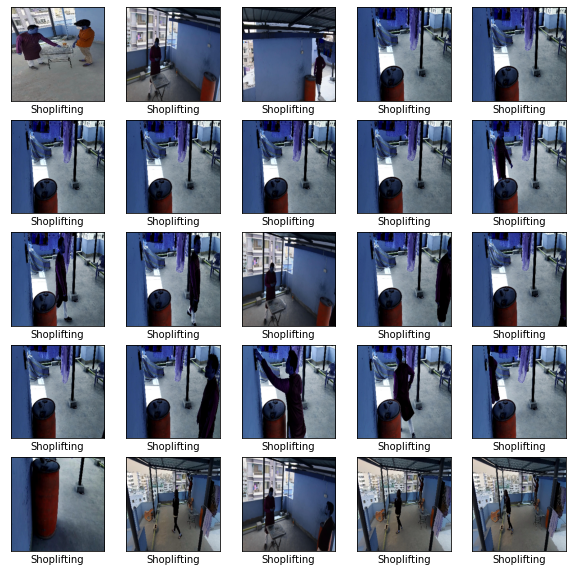

In [20]:
plot_image_data(data)

In [21]:
opt_adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=True)
opt_adam1= Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=0.1, amsgrad=True)
opt_sgd  = SGD(learning_rate=0.01, momentum=0.0, nesterov=False)
opt_sgd1 = SGD(learning_rate=0.01, momentum=0.5, nesterov=True)
opt_rms  = RMSprop(learning_rate=0.1, rho=0.9, momentum=0.9, epsilon=0.1, centered=True)

In [273]:
model_vgg16 = model_vgg16() #sgd, binary_crossentropy
model_vgg19 = model_vgg19() #sgd, binary_crossentropy
model_desnsenet121 = model_densenet121() #adam, categorical_crossentropy
# model = model_inceptionV3() #rms, hinge / 65% adam1, hinge, relu->dropout .75->sigmoid
# model = model_resnet50() #sgd1, binary_crossentropy
# augment_data_resnet()
# model = model_custom()

# print(model.summary())
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=False)

# summarize filter shapes
# for layer in model.layers:
#     # check for convolutional layer
#     print(layer.name)
#     if 'conv' not in layer.name:
#         continue

In [ ]:
# Split data
lb, train_x, test_x, train_y, test_y = split_data(data)

# Augment data
train_gen, validation_gen = augment_data(train_x, train_y, test_x, test_y)

# Train model
history = train_model(train_gen, validation_gen, len(train_x), len(test_x), model, 10, opt_sgd)

# Test Model
test_model(model, test_x, test_y)

In [219]:
history = get_kfold_history(data, model, opt_sgd)

Fold 1:
Epoch 1/10
63/63 [==============================] - 828s 13s/step - loss: 0.7300 - accuracy: 0.5975 - val_loss: 0.5054 - val_accuracy: 0.8833
Epoch 2/10
63/63 [==============================] - 836s 13s/step - loss: 0.5591 - accuracy: 0.6975 - val_loss: 0.4118 - val_accuracy: 0.9000
Epoch 3/10
 2/63 [..............................] - ETA: 5:20 - loss: 0.5000 - accuracy: 0.7500

KeyboardInterrupt: 

In [ ]:
model.save(outputmodelpath+"VGG19/")

save_history_as_csv(history, outputmodelpath+'VGG19/model.csv')

# lbinarizer = open(r"E:\Project\Python\Jupyter\Thesis\Fully Working\model\InceptionV3\binarizer.pkl", "wb")
# p.dump(lb, lbinarizer)
# lbinarizer.close()

In [ ]:
plot_data(history, 50)

In [114]:
lbinarizer = open(r"E:\Project\Python\Jupyter\Thesis\Fully Working\model\binarizer.pkl", "wb")
p.dump(lb, lbinarizer)
lbinarizer.close()

In [58]:
model = load_model(outputmodelpath+"VGG16/")

score = model.evaluate(train_x, train_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 7.764366216633789e-08
Test accuracy: 0.6552399396896362


In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

batch_size = [32, 64, 128]
epochs = [10, 50, 100]
loss = ['binary_crossentropy', 'categorical_crossentropy', 'mse']
optimizer = ['adam', 'sgd' 'rmsprop']

param_grid = dict(batch_size=batch_size, epochs=epochs)

# wrap the Keras model inside a scikit-learn estimator
model = KerasClassifier(build_fn=model_vgg16)
# model2 = KerasClassifier(build_fn=model_vgg19)
# model3 = KerasClassifier(build_fn=model_densenet121)


# Define the evaluation metric to use
scoring = 'accuracy'

# Split data
lb, train_x, test_x, train_y, test_y = split_data(data)

# perform the grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', n_jobs=-1, cv=3)
grid_result = grid.fit(test_x, test_y)

# print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

In [ ]:
# Create a list of tuples for models and their respective parameter grids
models_and_params = [
    (model_vgg16, param_grid),
    (model_vgg19, param_grid),
    (model_densenet121, param_grid)
]
# Perform grid search for each model
for model, param_grid in models_and_params:
    grid_search = GridSearchCV(model, param_grid, scoring=scoring, cv=5)
    grid_search.fit(test_x, test_y)
    print(f"Best parameters for {model.name}: {grid_search.best_params_}")
    print(f"Validation accuracy for best parameters: {grid_search.best_score_}")
